# Test segmentation spatialisation

In [353]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import chan_vese, felzenszwalb, quickshift

In [354]:
import imageio

In [355]:
image = imageio.imread('../_outTest/spatialisationResult.tif')

In [356]:
image[image < 0] = 0

In [357]:
# Feel free to play around with the parameters to see how they impact the result
cv = chan_vese(image, mu=1, lambda1=1, lambda2=1, tol=1e-3, max_iter=200,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

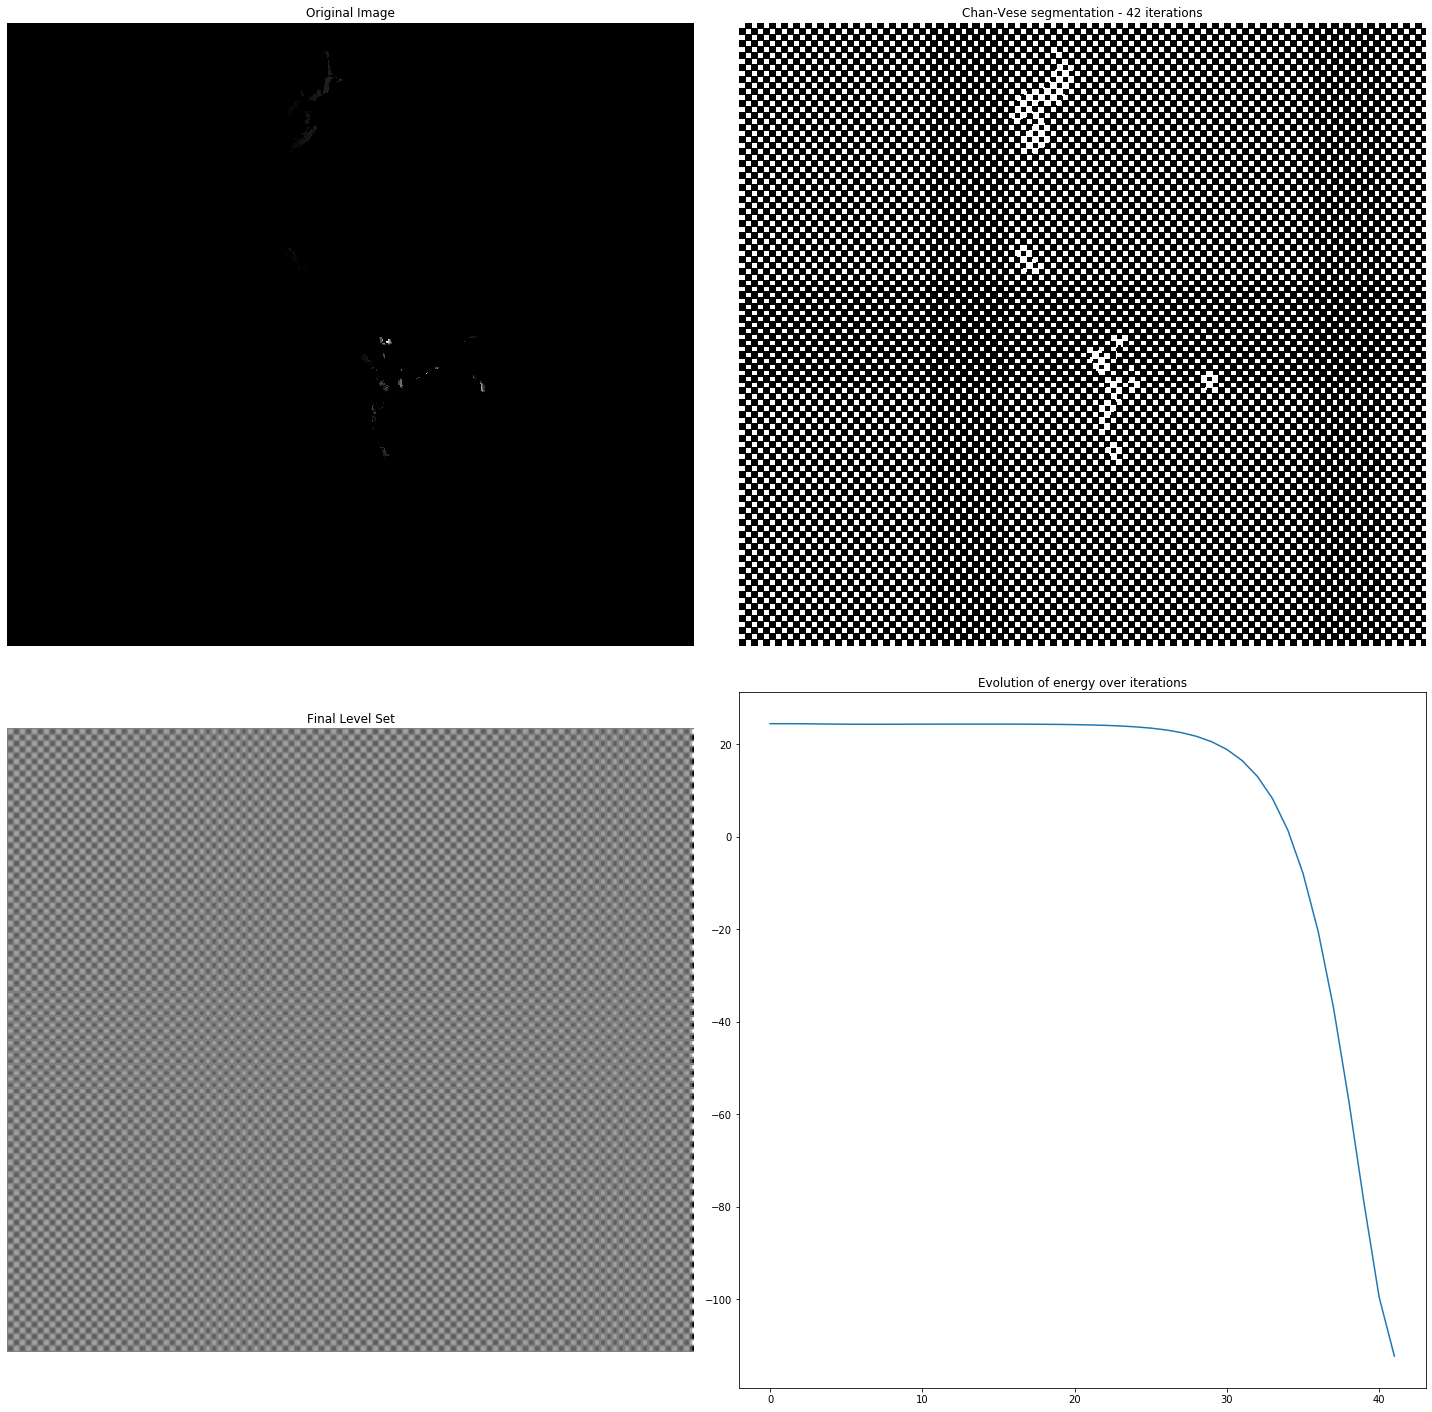

In [358]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

In [273]:
flz = felzenszwalb(image, scale=10, sigma=0.95, min_size=5)

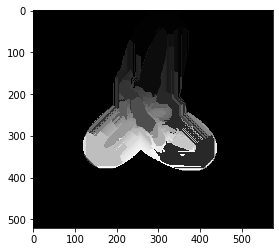

In [274]:
plt.imshow(flz, cmap="gray")

In [359]:
from skimage.filters.rank import entropy
from skimage.morphology import disk

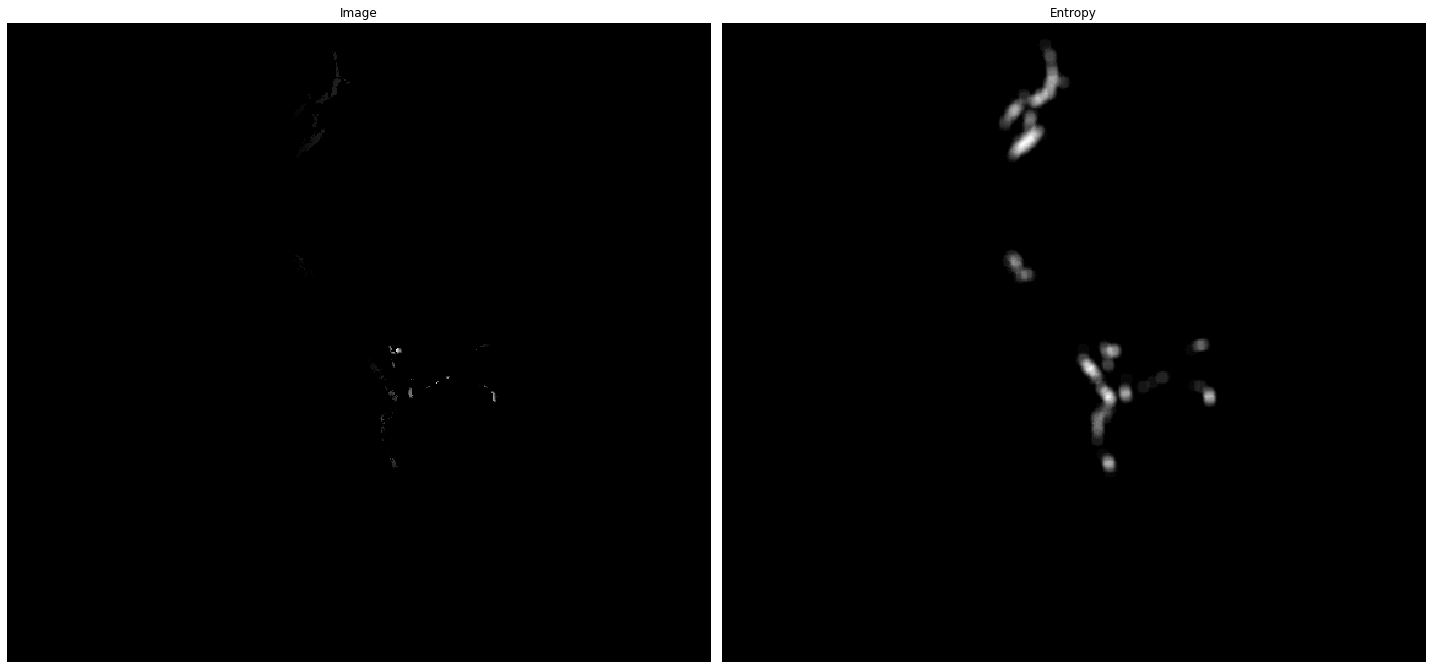

In [360]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20,20),
                               sharex=True, sharey=True)

img0 = ax0.imshow(image, cmap=plt.cm.gray)
ax0.set_title("Image")
ax0.axis("off")

img1 = ax1.imshow(entropy(image, disk(5)), cmap='gray')
ax1.set_title("Entropy")
ax1.axis("off")

fig.tight_layout()

plt.show()

In [277]:
from skimage.morphology import extrema

In [278]:
local_maxima = extrema.local_maxima(image)
local_minima = extrema.local_minima(image)

## Construction Métriques Évaluation

In [316]:
from skimage.draw import ellipse
from skimage.measure import regionprops, label
from functools import reduce

Segmentation image

In [317]:
# Image binaire
i = image.copy()
i[i > 0] = 1
i[i == np.min(image)] = 0

In [318]:
lb = label(i, connectivity=2, background=0)
lb2 = label(i, connectivity=1, background=0)

In [319]:
len(np.unique(lb))

66

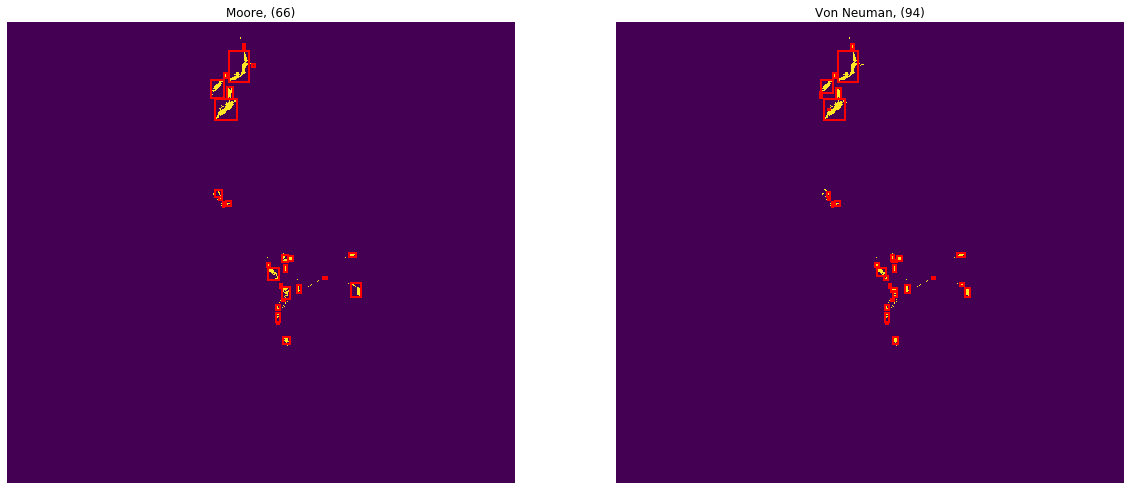

In [320]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 20))

#ax1.imshow(image, cmap='gray')
ax1.imshow(i)
ax2.imshow(i)

for region in regionprops(lb):
    # take regions with large enough areas
    if region.area >= 5:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax1.add_patch(rect)
     
for region in regionprops(lb2):
    # take regions with large enough areas
    if region.area >= 5:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax2.add_patch(rect)    

ax1.set_title('Moore, (%s)' % len(np.unique(lb)))
ax2.set_title('Von Neuman, (%s)'  % len(np.unique(lb2)))
ax1.set_axis_off()
ax2.set_axis_off()
#ax3.set_axis_off()

Descripteurs régions

In [321]:
rp = regionprops(lb, intensity_image=image)

In [322]:
parms = [{i:region[i] for i in region} for region in rp]

## Test fonctions de croyance (voir avec Ana-Maria)

In [286]:
class Fuzzyfier:
    """
    Classe permettant la fuzzification d'un raster net
    """

    def __init__(self, context):
        self.context = context

    def __str__(self):
        description_string = """fuzzyfier class  : {}
        parameters : {}
        uncertainty : {}
        """

        try:
            str_params = self.fuzzyfication_parameters
        except AttributeError:
            str_params = "no parameter"

        try:
            unc_params = self.certainty_parameters
        except AttributeError:
            unc_params = "no parameter"

        return description_string.format(
            self.__class__.__name__, str_params, unc_params
        )

    def fuzzyfy(self, raster, fuzzyfication_parameters, certainty=0.0):
        self.fuzzyfication_parameters = fuzzyfication_parameters
        self.certainty_parameters = certainty

        self.fuzzyfication_function = self.def_fuzzyfy_function(
            *self.fuzzyfication_parameters
        )

        # Calcul des valeurs
        fuzzyfied_raster = self.fuzzyfication_function(raster)
        self.set_uncertainty(fuzzyfied_raster, self.certainty_parameters)
        # Ajout 'nodata'
        nodata = self.context.raster_meta["nodata"]
        fuzzyfied_raster[raster == nodata] = nodata

        return fuzzyfied_raster

    def def_fuzzyfy_function(self, *args, **kwargs):
        raise NotImplementedError("No fuzzyfycation function constructor")

    def set_uncertainty(self, raster, certainty=0.0):
        if certainty != 0.0:
            raster[raster < certainty] = certainty
class FuzzyfierMoreSpeeeeed(Fuzzyfier):
    def __init__(self, context):
        super().__init__(context)

    def def_fuzzyfy_function(self, *args, **kwargs):
        """
        fonction chargée de la génération de la fonction "fuzzy_fun".
        "fuzzy_fun" crée une copie fuzzyfiée du raster donné en entrée.
        """

        # Tri des paramètres
        sorted(args, key=lambda x: x[0])
        largs = len(args)
        # Définition de la fonction
        # Liste de patterns en fonction du nombre de paramètres
        fun_rules = {
            # Cas crisp
            1: (self._inf_vals,),
            # Cas où la fonction est une droite
            2: (self._inf_vals, self._fst_slp, self._sup_vals),
            # la fonction est de forme triangulaire
            3: (self._inf_vals, self._fst_slp, self._lst_slp, self._sup_vals),
            # forme trapézoidale
            4: (
                self._inf_vals,
                self._fst_slp,
                self._cnt_flt,
                self._lst_slp,
                self._sup_vals,
            ),
        }

        # Caneva de la fonction "fuzzy fun"
        def fuzzy_fun(raster):
            raster_copy = np.zeros_like(raster)
            try:
                # On récupère la liste d'instruction correspondant au nombre d'arguments
                for ins in fun_rules[largs]:
                    # On applique les fonctions, dans l'ordre du tuple "fun_rules[largs]"
                    ins(raster, raster_copy, *args)
                return raster_copy
            except KeyError:
                raise ValueError("2, 3 or 4 parameters needed")

        # Renvoi de la fonction générée
        return fuzzy_fun

    def _inf_vals(self, r, r_copy, *args):
        # degré flou des valeurs inf au plus petit paramètre
        r_copy[r < args[0][0]] = args[0][1]

    def _fst_slp(self, r, r_copy, *args):
        # degré flou des valeurs par la première pente
        a = (args[1][1] - args[0][1]) / (args[1][0] - args[0][0])
        b = -(args[0][0] * a - args[0][1])
        r_copy[(r >= args[0][0]) & (r < args[1][0])] = (
            r[(r >= args[0][0]) & (r < args[1][0])] * a + b
        )

    def _cnt_flt(self, r, r_copy, *args):
        # degré flou des valeurs par le plat central
        r_copy[(r >= args[1][0]) & (r < args[-2][0])] = args[-2][1]

    def _lst_slp(self, r, r_copy, *args):
        # degré flou des valeurs par la seconde pente
        lv = args[-1]
        alv = args[-2]
        a = (lv[1] - alv[1]) / (lv[0] - alv[0])
        b = -(alv[0] * a - alv[1])
        r_copy[(r >= alv[0]) & (r < lv[0])] = r[(r >= alv[0]) & (r < lv[0])] * a + b

    def _sup_vals(self, r, r_copy, *args):
        # degré flou des valeurs sup au plus grand paramètre
        r_copy[r >= args[-1][0]] = args[-1][1]


In [287]:
class HypothesisSet:
    def __init__(self, knowledge, partial_knowledge, ignorance, conflict=0):

        if not sum([knowledge, partial_knowledge, ignorance, conflict]) == 1:
            pass
            #print(knowledge, partial_knowledge, ignorance, conflict)
            #raise ValueError("The sum of values must be 1")

        self.knowledge = knowledge
        self.partial_knowledge = partial_knowledge
        self.ignorance = ignorance
        self.conflict = conflict

    def __or__(self, other):

        conflict_mass = (
            self.knowledge * other.partial_knowledge
            + self.partial_knowledge * other.knowledge
        )
         
        ignorance_mass = self.ignorance * other.ignorance
        
        partial_knowledge_mass = (
            self.partial_knowledge * other.partial_knowledge
            + self.ignorance * other.partial_knowledge
            + self.partial_knowledge * other.ignorance
        )
        knowledge_mass = (
            self.knowledge * other.knowledge
            + self.knowledge * other.ignorance
            + self.ignorance * other.knowledge
        )

        return HypothesisSet(
            knowledge_mass, partial_knowledge_mass, ignorance_mass, conflict_mass
        )
    
    def __iter__(self):
        return iter([self.knowledge, self.partial_knowledge, self.ignorance, self.conflict])
    
    def __repr__(self):
        return "HypothesisSet(%s,%s,%s,%s)" % (self.knowledge, self.partial_knowledge, self.ignorance, self.conflict)

    def __str__(self):
        return "%s %s %s %s" % (self.knowledge, self.partial_knowledge, self.ignorance, self.conflict)

In [288]:
ff = FuzzyfierMoreSpeeeeed(1)
def mass_size(psize):
    fun_kw = ff.def_fuzzyfy_function((0,0),(0.25,1),(1,0))
    fun_pkw = ff.def_fuzzyfy_function((0,1),(0.25,0))
    fun_ign = ff.def_fuzzyfy_function((0.25,0),(1,1))
    
    return HypothesisSet(fun_kw(psize), fun_pkw(psize), fun_ign(psize))

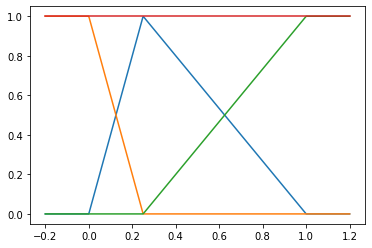

In [289]:
fun_kw = ff.def_fuzzyfy_function((0,0),(0.25,1),(1,0))
fun_pkw = ff.def_fuzzyfy_function((0,1),(0.25,0))
fun_ign = ff.def_fuzzyfy_function((0.25,0),(1,1))

x = np.linspace(-0.2, 1.2, 500)

plt.plot(x, fun_kw(x))
plt.plot(x, fun_pkw(x))
plt.plot(x, fun_ign(x))
plt.plot(x, fun_pkw(x) + fun_kw(x) + fun_ign(x) )

In [290]:
ff = FuzzyfierMoreSpeeeeed(1)
def mass_eccentricity(eccentricity):
    fun_kw = ff.def_fuzzyfy_function((0, 0.8),(1, 0.4))
    fun_pkw = ff.def_fuzzyfy_function((0,0.2),(1,0.4))
    fun_ign = ff.def_fuzzyfy_function((0,0),(1,0.2))
    
    return HypothesisSet(fun_kw(eccentricity), fun_pkw(eccentricity), fun_ign(eccentricity))

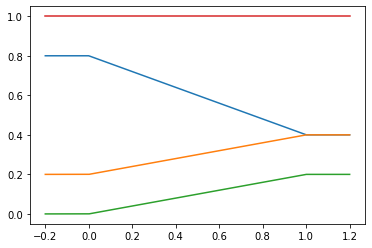

In [291]:
fun_kw = ff.def_fuzzyfy_function((0, 0.8),(1, 0.4))
fun_pkw = ff.def_fuzzyfy_function((0,0.2),(1,0.4))
fun_ign = ff.def_fuzzyfy_function((0,0),(1,0.2))

x = np.linspace(-0.2, 1.2, 500)

plt.plot(x, fun_kw(x))
plt.plot(x, fun_pkw(x))
plt.plot(x, fun_ign(x))
plt.plot(x, fun_pkw(x) + fun_kw(x) + fun_ign(x) )

Calcul des valeurs pour chaque zone

In [292]:
total_area = len(image)

hyp_list = []
for i in rp:
    pa = i.area / total_area
    ec = np.array(i.eccentricity, np.float)
    hyp_list.append(mass_eccentricity(ec) | mass_size(pa) | mass_eccentricity(ec))

In [293]:
[sum(i) for i in hyp_list]

[1.0000000000000002]

Fusion des objets

In [294]:
obj = []
conf = 1 / (1 - reduce(lambda x,y: x* y ,[h.conflict for h in hyp_list]))
for i,v in enumerate(hyp_list):
    xx = v.knowledge * reduce(lambda x,y: x* y ,[h.partial_knowledge + h.ignorance for h in hyp_list[:i] + hyp_list[i + 1:]])
    obj.append(xx*conf)

TypeError: reduce() of empty sequence with no initial value

In [ ]:
conf = 1 / (1 - reduce(lambda x,y: x* y ,[h.conflict for h in hyp_list]))
na = conf * reduce(lambda x,y: x* y ,[h.partial_knowledge for h in hyp_list])

In [ ]:
conf = reduce(lambda x,y: x* y ,[h.conflict for h in hyp_list])

In [ ]:
sum(obj + [na] + [conf])

## Max tree

In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4),
                               sharex=True, sharey=True)

img0 = ax0.imshow(local_maxima)
ax0.set_title("Image")
ax0.axis("off")

img1 = ax1.imshow(local_minima)
ax1.set_title("Image")
ax1.axis("off")

In [ ]:
from skimage.morphology import convex_hull_object, label

In [ ]:
cvxh = convex_hull_object(image,connectivity=2)

In [ ]:
plt.imshow(label(image, background=0))

In [ ]:
from matplotlib.lines import Line2D
from skimage.morphology import max_tree
import networkx as nx
import vtk
from writeNodesEdges import writeObjects

In [ ]:
P, S = max_tree(image)

P_rav = P.ravel()

In [ ]:
canonical_max_tree = nx.DiGraph()
canonical_max_tree.add_nodes_from(S)
for node in canonical_max_tree.nodes():
    canonical_max_tree.nodes[node]['value'] = image_rav[node]
canonical_max_tree.add_edges_from([(n, P_rav[n]) for n in S[1:]])

In [ ]:
y,x = np.indices(image.shape)

In [ ]:
np.max(P)

In [ ]:
xyz = list(zip(x.ravel(), y.ravel(), (S.ravel()*0.01)))

In [ ]:
def writeObjects(nodeCoords,
                 edges = [],
                 scalar = [], name = '', power = 1,
                 scalar2 = [], name2 = '', power2 = 1,
                 nodeLabel = [],
                 method = 'vtkPolyData',
                 fileout = 'test'):
    """
    Store points and/or graphs as vtkPolyData or vtkUnstructuredGrid.
    Required argument:
    - nodeCoords is a list of node coordinates in the format [x,y,z]
    Optional arguments:
    - edges is a list of edges in the format [nodeID1,nodeID2]
    - scalar/scalar2 is the list of scalars for each node
    - name/name2 is the scalar's name
    - power/power2 = 1 for r~scalars, 0.333 for V~scalars
    - nodeLabel is a list of node labels
    - method = 'vtkPolyData' or 'vtkUnstructuredGrid'
    - fileout is the output file name (will be given .vtp or .vtu extension)
    """

    points = vtk.vtkPoints()
    for node in nodeCoords:
        points.InsertNextPoint(node)

    if edges:
        line = vtk.vtkCellArray()
        line.Allocate(len(edges))
        for edge in edges:
            line.InsertNextCell(2)
            line.InsertCellPoint(edge[0])
            line.InsertCellPoint(edge[1])   # line from point edge[0] to point edge[1]

    if scalar:
        attribute = vtk.vtkFloatArray()
        attribute.SetNumberOfComponents(1)
        attribute.SetName(name)
        attribute.SetNumberOfTuples(len(scalar))
        for i, j in enumerate(scalar):   # i becomes 0,1,2,..., and j runs through scalars
            attribute.SetValue(i,j**power)

    if scalar2:
        attribute2 = vtk.vtkFloatArray()
        attribute2.SetNumberOfComponents(1)
        attribute2.SetName(name2)
        attribute2.SetNumberOfTuples(len(scalar2))
        for i, j in enumerate(scalar2):   # i becomes 0,1,2,..., and j runs through scalar2
            attribute2.SetValue(i,j**power2)

    if nodeLabel:
        label = vtk.vtkStringArray()
        label.SetName('tag')
        label.SetNumberOfValues(len(nodeLabel))
        for i, j in enumerate(nodeLabel):   # i becomes 0,1,2,..., and j runs through scalar
            label.SetValue(i,j)

    if method == 'vtkPolyData':
        polydata = vtk.vtkPolyData()
        polydata.SetPoints(points)
        if edges:
            polydata.SetLines(line)
        if scalar:
            polydata.GetPointData().AddArray(attribute)
        if scalar2:
            polydata.GetPointData().AddArray(attribute2)
        if nodeLabel:
            polydata.GetPointData().AddArray(label)
        writer = vtk.vtkXMLPolyDataWriter()
        writer.SetFileName(fileout+'.vtp')
        writer.SetInputData(polydata)
        writer.Write()
    elif method == 'vtkUnstructuredGrid':
        # caution: ParaView's Tube filter does not work on vtkUnstructuredGrid
        grid = vtk.vtkUnstructuredGrid()
        grid.SetPoints(points)
        if edges:
            grid.SetCells(vtk.VTK_LINE, line)
        if scalar:
            grid.GetPointData().AddArray(attribute)
        if scalar2:
            grid.GetPointData().AddArray(attribute2)
        if nodeLabel:
            grid.GetPointData().AddArray(label)
        writer = vtk.vtkXMLUnstructuredGridWriter()
        writer.SetFileName(fileout+'.vtu')
        writer.SetInputData(grid)
        writer.Write()

In [ ]:
writeObjects(xyz, edges=canonical_max_tree.edges(), fileout="network")

## Inférence floue

In [323]:
import skfuzzy as fuzz

In [324]:
# Univers des variables
x_taille = np.arange(0, 1.1, 0.01)
x_valeur = np.arange(0, 1.1, 0.01)
x_note = np.arange(0, 1.1, 0.01)

Définition des fonctions d'appartenance

In [325]:
# Generate fuzzy membership functions
petit = fuzz.trimf(x_taille, [0, 0, .1])
moyen = fuzz.trimf(x_taille, [0, .1, .2])
grand = fuzz.trapmf(x_taille, [.1, .2,1,1])

faible = fuzz.trimf(x_valeur, [0, 0, .5])
moyenne = fuzz.trimf(x_valeur, [0, .5, 1])
forte = fuzz.trimf(x_valeur, [.5, 1, 1])

note_lo = fuzz.trimf(x_note, [0, 0, .5])
note_md = fuzz.trimf(x_note, [0, .5, 1])
note_hi = fuzz.trimf(x_note, [.5, 1, 1])

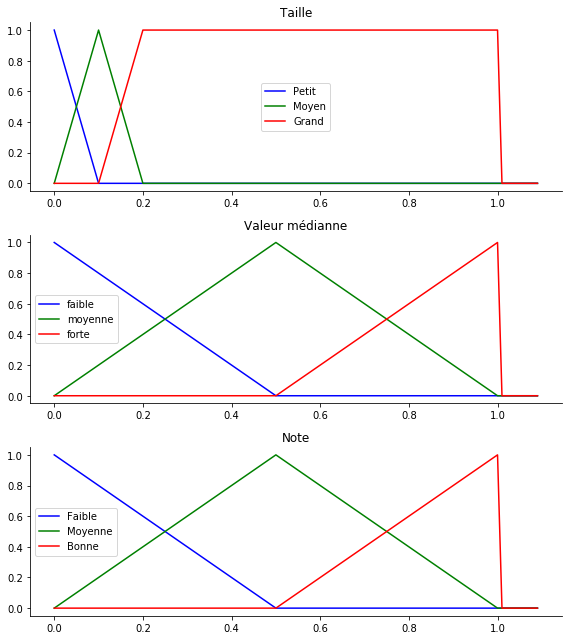

In [326]:
# Visualize these universes and membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(x_taille, petit, 'b', linewidth=1.5, label='Petit')
ax0.plot(x_taille, moyen, 'g', linewidth=1.5, label='Moyen')
ax0.plot(x_taille, grand, 'r', linewidth=1.5, label='Grand')
ax0.set_title('Taille')
ax0.legend()

ax1.plot(x_valeur, faible, 'b', linewidth=1.5, label='faible')
ax1.plot(x_valeur, moyenne, 'g', linewidth=1.5, label='moyenne')
ax1.plot(x_valeur, forte, 'r', linewidth=1.5, label='forte')
ax1.set_title('Valeur médianne')
ax1.legend()

ax2.plot(x_note, note_lo, 'b', linewidth=1.5, label='Faible')
ax2.plot(x_note, note_md, 'g', linewidth=1.5, label='Moyenne')
ax2.plot(x_note, note_hi, 'r', linewidth=1.5, label='Bonne')
ax2.set_title('Note')
ax2.legend()

# Turn off top/right axes
for ax in(ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
plt.tight_layout()

In [415]:
taille_val = (parms[27]['area'] / np.size(image))
valeur_val = parms[27]['max_intensity']

In [416]:
# We need the activation of our fuzzy membership functions at these values.
# The exact values 6.5 and 9.8 do not exist on our universes...
# This is what fuzz.interp_membership exists for!
taille_level_lo = fuzz.interp_membership(x_taille, petit, taille_val)
taille_level_md = fuzz.interp_membership(x_taille, moyen, taille_val)
taille_level_hi = fuzz.interp_membership(x_taille, grand, taille_val)

valeur_level_lo = fuzz.interp_membership(x_valeur, faible, valeur_val)
valeur_level_md = fuzz.interp_membership(x_valeur, moyenne, valeur_val)
valeur_level_hi = fuzz.interp_membership(x_valeur, forte, valeur_val)

In [417]:
fuzz.interp_membership(x_valeur, forte, 1)

1.0

Définition des règles

In [418]:
# Régle forte
# Si
active_rule1 = np.fmin(np.fmax(taille_level_lo, taille_level_md), valeur_level_hi)
# Alors
note_activation_hi = np.fmin(active_rule1, note_hi)

In [419]:
# Régle faible
# Si
active_rule2 = np.fmax(np.fmax(np.fmin(taille_level_hi, valeur_level_lo), np.fmin(taille_level_lo, valeur_level_lo)), np.fmin(taille_level_hi, valeur_level_hi))
# Alors
note_activation_lo = np.fmin(active_rule2, note_lo)

In [420]:
# Régle moyenne
# Si
active_rule3 = np.fmin(taille_level_md, valeur_level_md)
# Alors
note_activation_md = np.fmin(active_rule3, note_md)

Visualisation des règles

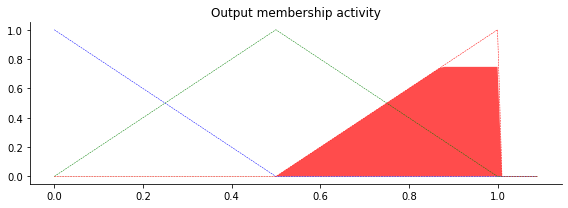

In [421]:
note0 = np.zeros_like(x_note)
# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.fill_between(x_note, note0, note_activation_lo, facecolor='b', alpha=0.7)
ax0.plot(x_note, note_lo, 'b', linewidth=0.5, linestyle='--', )

ax0.fill_between(x_note, note0, note_activation_md, facecolor='g', alpha=0.7)
ax0.plot(x_note, note_md, 'g', linewidth=0.5, linestyle='--')

ax0.fill_between(x_note, note0, note_activation_hi, facecolor='r', alpha=0.7)
ax0.plot(x_note, note_hi, 'r', linewidth=0.5, linestyle='--')
ax0.set_title('Output membership activity')

# Turn off top/right axes
for ax in(ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
plt.tight_layout()

Aggrégation des fonctions de résultat

In [422]:
# Aggregate all three output membership functions together
aggregated = np.fmax(note_activation_lo,np.fmax(note_activation_md, note_activation_hi))

Défuzyfication

In [423]:
# Calculate defuzzified result
note = fuzz.defuzz(x_note, aggregated, 'centroid')
note_activation = fuzz.interp_membership(x_note, aggregated, note)

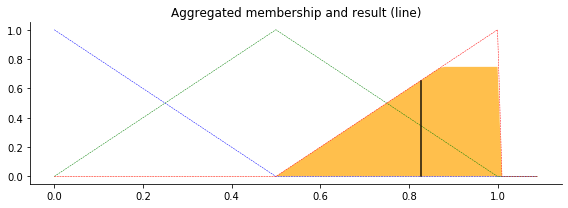

In [424]:
# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))
ax0.plot(x_note, note_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.plot(x_note, note_md, 'g', linewidth=0.5, linestyle='--')
ax0.plot(x_note, note_hi, 'r', linewidth=0.5, linestyle='--')
ax0.fill_between(x_note, note0, aggregated, facecolor='Orange', alpha=0.7)
ax0.plot([note, note], [0, note_activation], 'k', linewidth=1.5, alpha=0.9)
ax0.set_title('Aggregated membership and result (line)')

# Turn off top/right axes
for ax in(ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
plt.tight_layout()

## Bouclette

In [401]:
notes = []
for prm in parms:
    # Variables
    taille_val = (prm['area'] / np.size(image))
    valeur_val = prm['max_intensity']
    # Fuzzyfication
    taille_level_lo = fuzz.interp_membership(x_taille, petit, taille_val)
    taille_level_md = fuzz.interp_membership(x_taille, moyen, taille_val)
    taille_level_hi = fuzz.interp_membership(x_taille, grand, taille_val)
    valeur_level_lo = fuzz.interp_membership(x_valeur, faible, valeur_val)
    valeur_level_md = fuzz.interp_membership(x_valeur, moyenne, valeur_val)
    valeur_level_hi = fuzz.interp_membership(x_valeur, forte, valeur_val)
    # Régle forte
    active_rule1 = np.fmin(taille_level_lo, valeur_level_hi)
    note_activation_hi = np.fmin(active_rule1, note_hi)
    # Régle faible
    active_rule2 = np.fmax(np.fmax(np.fmin(taille_level_hi, valeur_level_lo), np.fmin(taille_level_lo, valeur_level_lo)), np.fmin(taille_level_hi, valeur_level_hi))
    note_activation_lo = np.fmin(active_rule2, note_lo)
    # Régle moyenne
    active_rule3 = np.fmin(taille_level_md, valeur_level_md)
    note_activation_md = np.fmin(active_rule3, note_md)
    # Aggrégation
    aggregated = np.fmax(note_activation_lo,np.fmax(note_activation_md, note_activation_hi))
    # Defuzzyfication
    try:
        note = fuzz.defuzz(x_note, aggregated, 'centroid')
    except:
        print(taille_level_lo, valeur_val)
    notes.append(note)

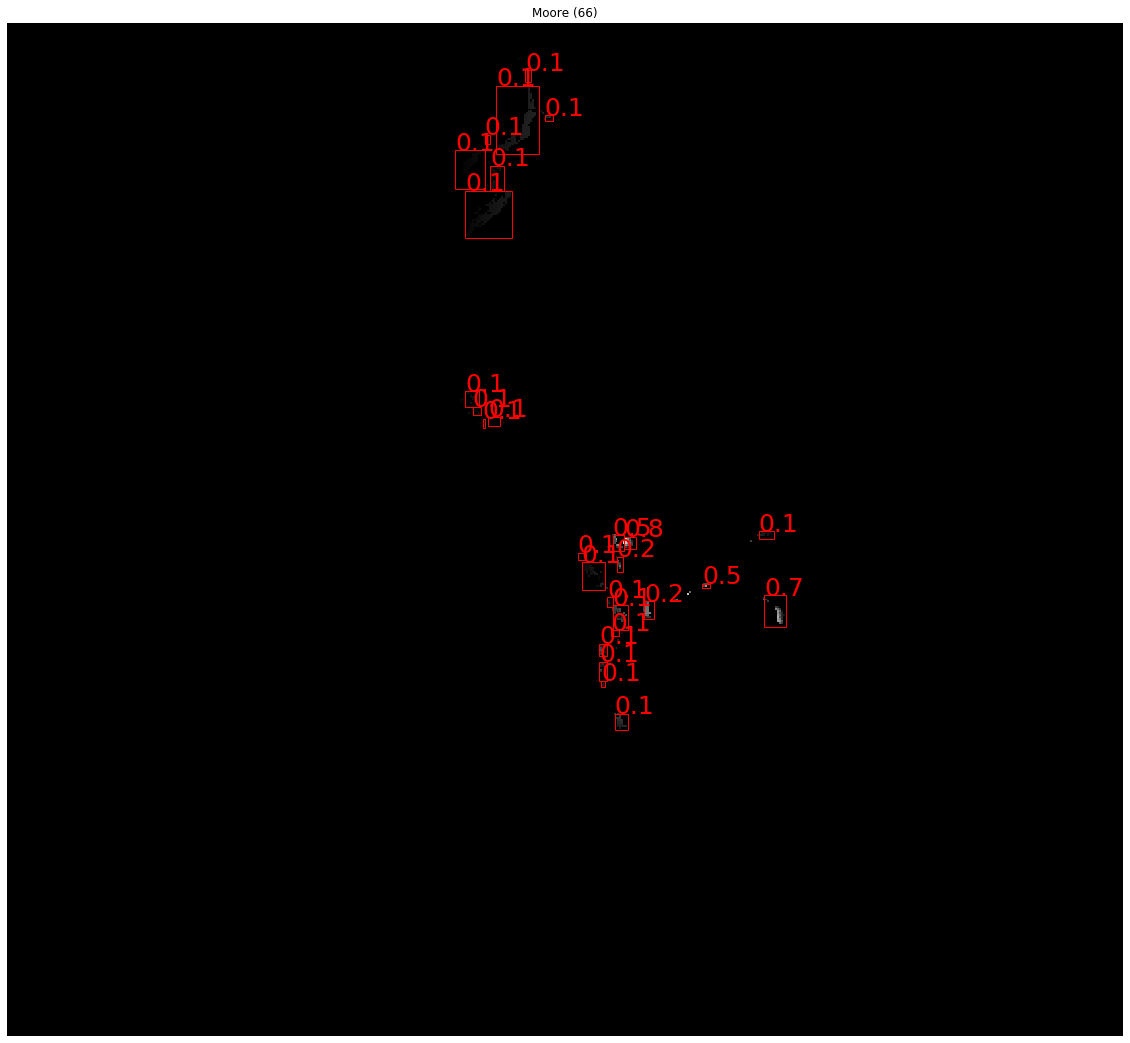

In [403]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax1, = plt.subplots(figsize=(20, 20))


ax1.imshow(image, cmap='gray')

for region, note in zip(regionprops(lb),notes):
    # take regions with large enough areas
    if region.area >= 5:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=1)
        ax1.add_patch(rect)
        ax1.text(minc, minr, "%.3s"%note, fontsize=25, color="red")

ax1.set_title('Moore (%s)' % len(np.unique(lb)))
ax1.set_axis_off()